# Lectura y Análisis

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [47]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [48]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2024-03-01"
end_date = "2025-02-28"

location = "cristianos"

grafcan = "grafcan_cristianos"
openmeteo_arpege = "openmeteo_cristianos_arpege"
openmeteo_icon = "openmeteo_cristianos_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_cristianos...
air_temperature           18.357235
atmospheric_pressure    1015.892660
relative_humidity         62.515001
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           18.834167
atmospheric_pressure    1013.578013
relative_humidity         65.149445
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_cristianos_arpege...
air_temperature           16.5
atmospheric_pressure    1016.8
relative_humidity         86.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           16.1
atmospheric_pressure    1015.0
relative_humidity         91.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_cristianos_icon...
air_temperature           19.3
atmospheric_pressure    1016.5
relative_humidity         67.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.1
atmospheric_pressure    1015.3
relative_humidity         89.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [49]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


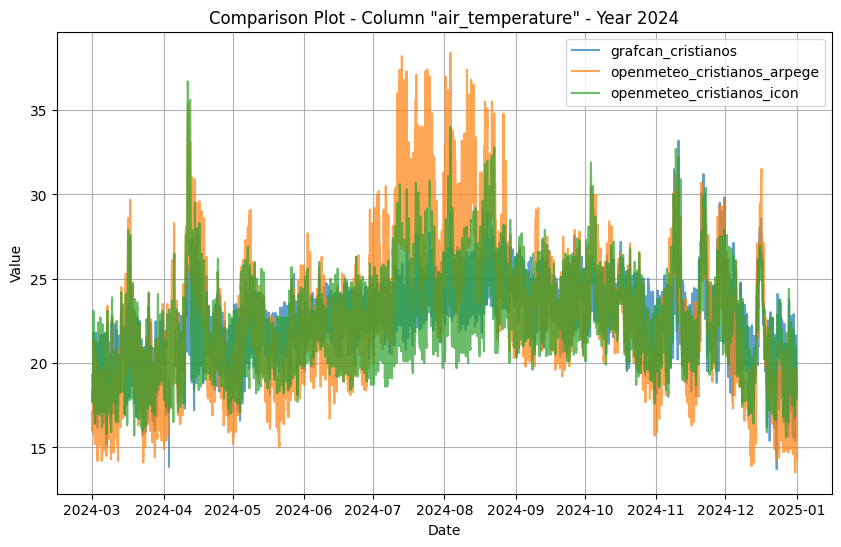

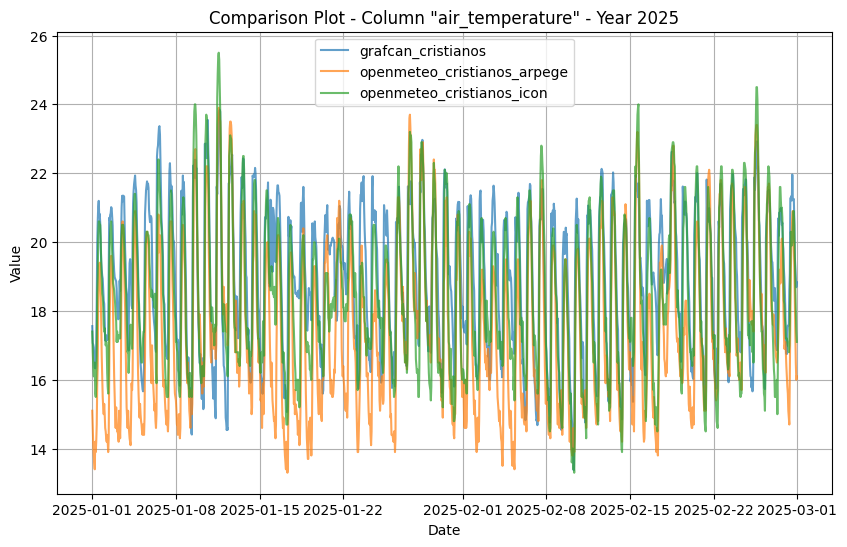

Plotting relative_humidity


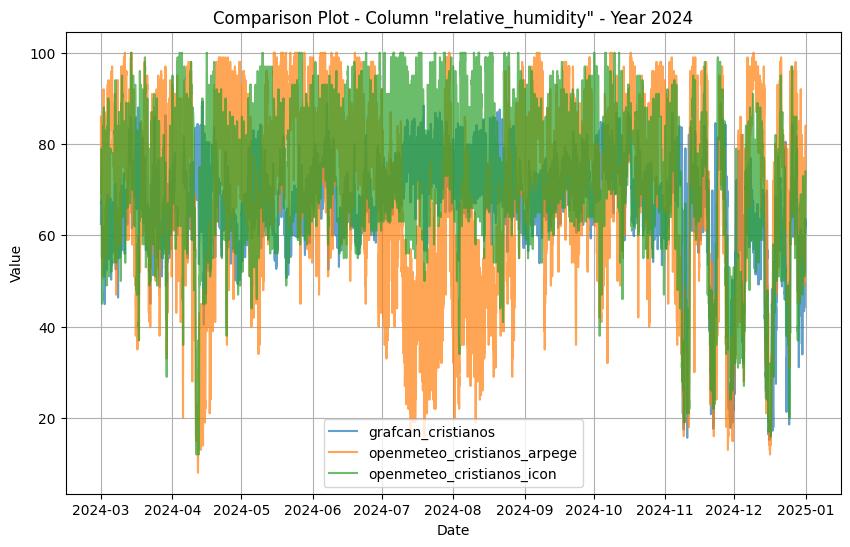

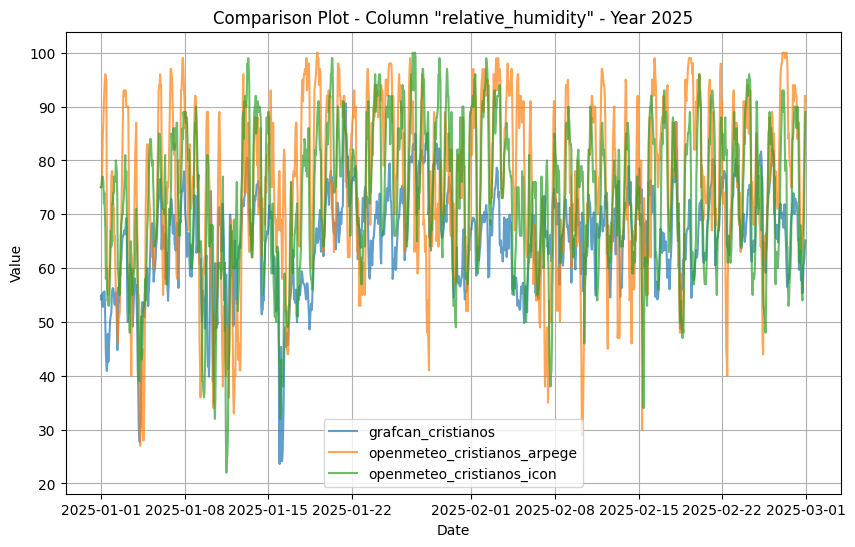

Plotting atmospheric_pressure


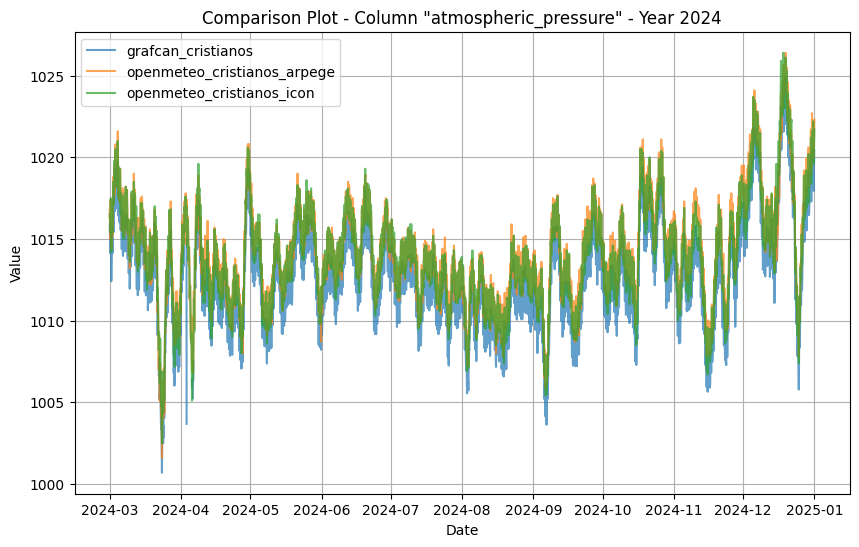

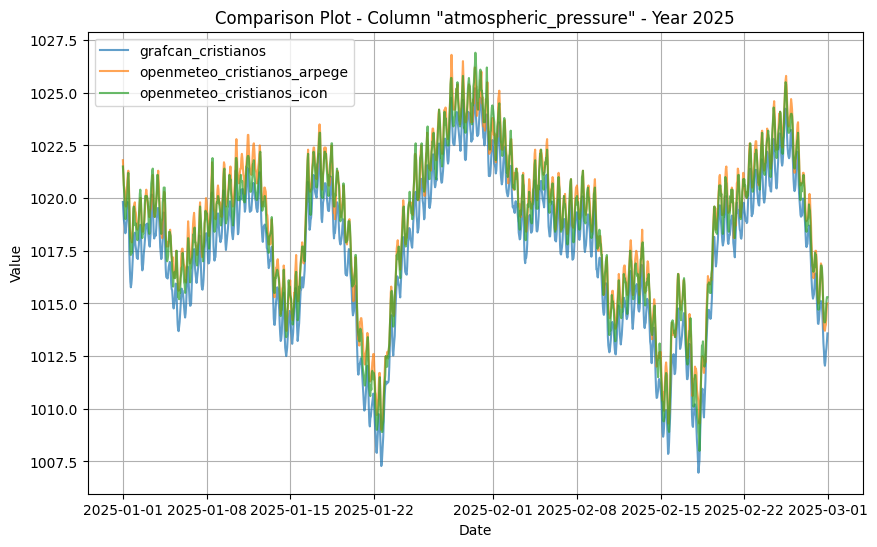

In [50]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [51]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_cristianos after resampling:
[Timestamp('2024-03-22 00:00:00+0000', tz='UTC'), Timestamp('2024-03-22 01:00:00+0000', tz='UTC'), Timestamp('2024-03-22 02:00:00+0000', tz='UTC'), Timestamp('2024-03-22 04:00:00+0000', tz='UTC'), Timestamp('2024-03-22 05:00:00+0000', tz='UTC'), Timestamp('2024-03-22 06:00:00+0000', tz='UTC'), Timestamp('2024-04-02 05:00:00+0000', tz='UTC'), Timestamp('2024-04-02 06:00:00+0000', tz='UTC'), Timestamp('2024-04-02 07:00:00+0000', tz='UTC'), Timestamp('2024-04-02 08:00:00+0000', tz='UTC'), Timestamp('2024-04-02 11:00:00+0000', tz='UTC'), Timestamp('2024-04-02 12:00:00+0000', tz='UTC'), Timestamp('2024-04-02 14:00:00+0000', tz='UTC'), Timestamp('2024-04-02 15:00:00+0000', tz='UTC'), Timestamp('2024-04-02 16:00:00+0000', tz='UTC'), Timestamp('2024-04-02 17:00:00+0000', tz='UTC'), Timestamp('2024-04-02 18:00:00+0000', tz='UTC'), Timestamp('2024-04-02 19:00:00+0000', tz='UTC'), Timestamp('2024-04-02 20:00:00+0000', tz='UTC'), Timestamp('202

### Manejo Horas faltantes

In [52]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= 5 hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [53]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [54]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [55]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_cristianos_icon vs grafcan_cristianos
  air_temperature:
    Pearson: 0.8653
    Spearman: 0.8971
    Kendall: 0.7318
    MSE: 2.7269
    Euclidean Distance: 154.5560
  atmospheric_pressure:
    Pearson: 0.9868
    Spearman: 0.9891
    Kendall: 0.9227
    MSE: 2.4538
    Euclidean Distance: 146.6126
  relative_humidity:
    Pearson: 0.6221
    Spearman: 0.5798
    Kendall: 0.4211
    MSE: 190.3955
    Euclidean Distance: 1291.4583


In [56]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_cristianos_arpege vs grafcan_cristianos
  air_temperature:
    Pearson: 0.7878
    Spearman: 0.8357
    Kendall: 0.6445
    MSE: 8.7615
    Euclidean Distance: 277.0392
  atmospheric_pressure:
    Pearson: 0.9859
    Spearman: 0.9878
    Kendall: 0.9160
    MSE: 3.2053
    Euclidean Distance: 167.5654
  relative_humidity:
    Pearson: 0.1158
    Spearman: -0.0364
    Kendall: -0.0242
    MSE: 490.5226
    Euclidean Distance: 2072.9153


### Selección de datasets

In [57]:
new_df_openmeteo = "openmeteo_" + location
dataframes[new_df_openmeteo] = dataframes[openmeteo_icon].copy()

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [58]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_cristianos:


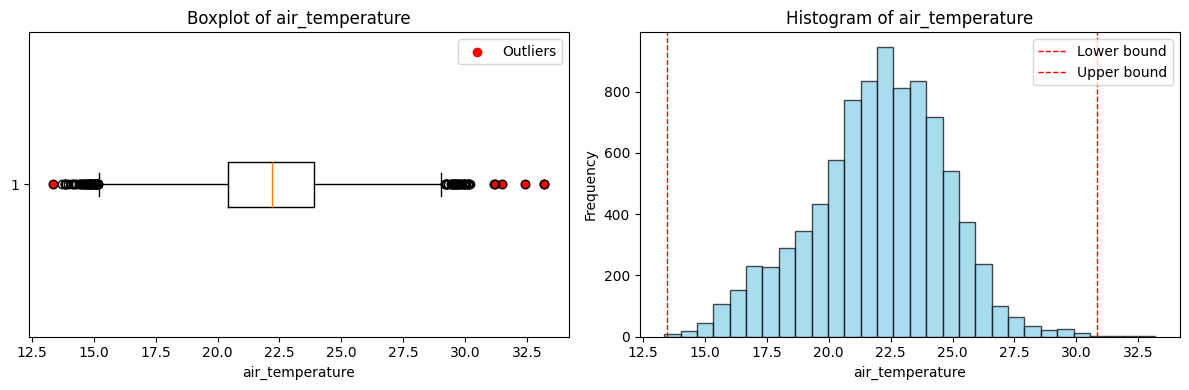

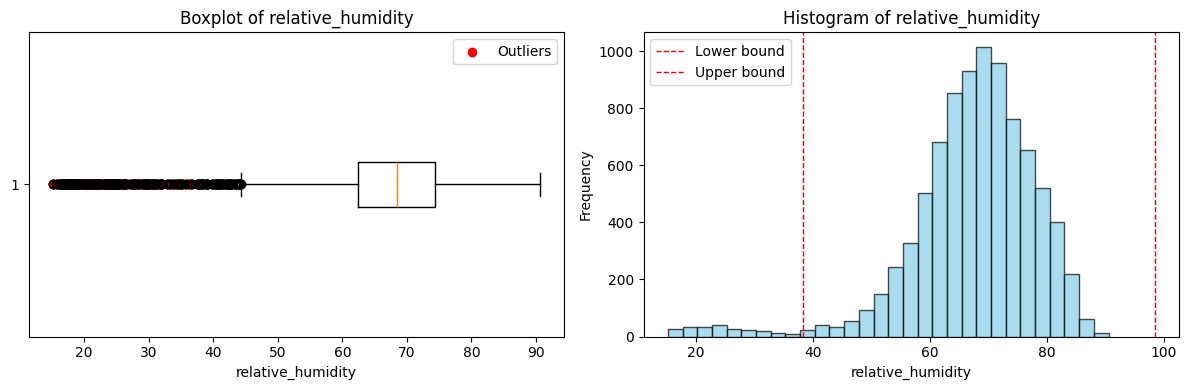

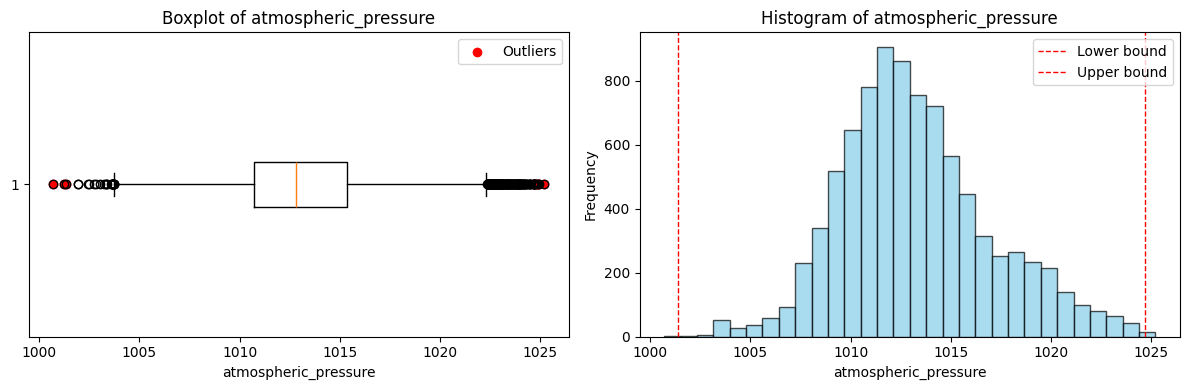

  air_temperature outlier row indices: [Timestamp('2024-11-08 17:00:00+0000', tz='UTC'), Timestamp('2024-11-10 14:00:00+0000', tz='UTC'), Timestamp('2024-11-10 15:00:00+0000', tz='UTC'), Timestamp('2024-11-10 16:00:00+0000', tz='UTC'), Timestamp('2024-11-21 11:00:00+0000', tz='UTC'), Timestamp('2024-11-21 12:00:00+0000', tz='UTC'), Timestamp('2025-02-10 07:00:00+0000', tz='UTC')]
  relative_humidity outlier row indices: [Timestamp('2024-04-03 00:00:00+0000', tz='UTC'), Timestamp('2024-04-04 00:00:00+0000', tz='UTC'), Timestamp('2024-11-08 17:00:00+0000', tz='UTC'), Timestamp('2024-11-08 23:00:00+0000', tz='UTC'), Timestamp('2024-11-09 02:00:00+0000', tz='UTC'), Timestamp('2024-11-10 10:00:00+0000', tz='UTC'), Timestamp('2024-11-10 13:00:00+0000', tz='UTC'), Timestamp('2024-11-10 14:00:00+0000', tz='UTC'), Timestamp('2024-11-10 15:00:00+0000', tz='UTC'), Timestamp('2024-11-10 16:00:00+0000', tz='UTC'), Timestamp('2024-11-20 12:00:00+0000', tz='UTC'), Timestamp('2024-11-20 13:00:00+0000'

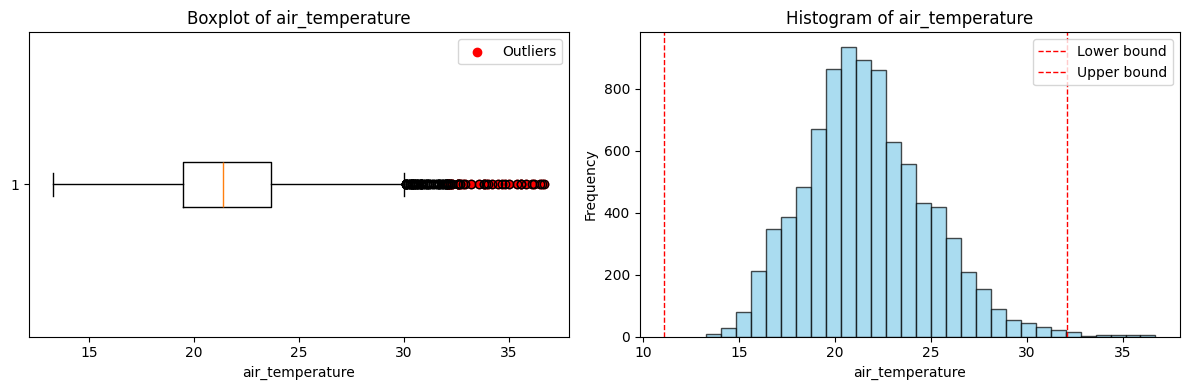

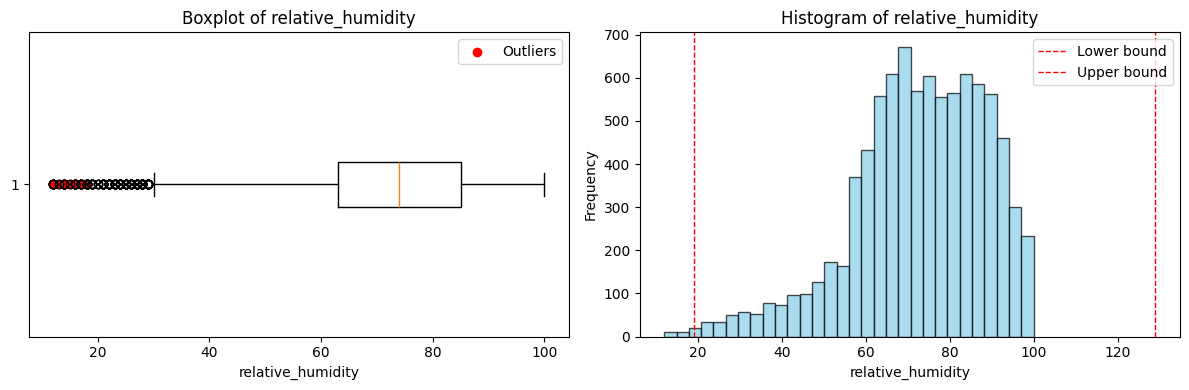

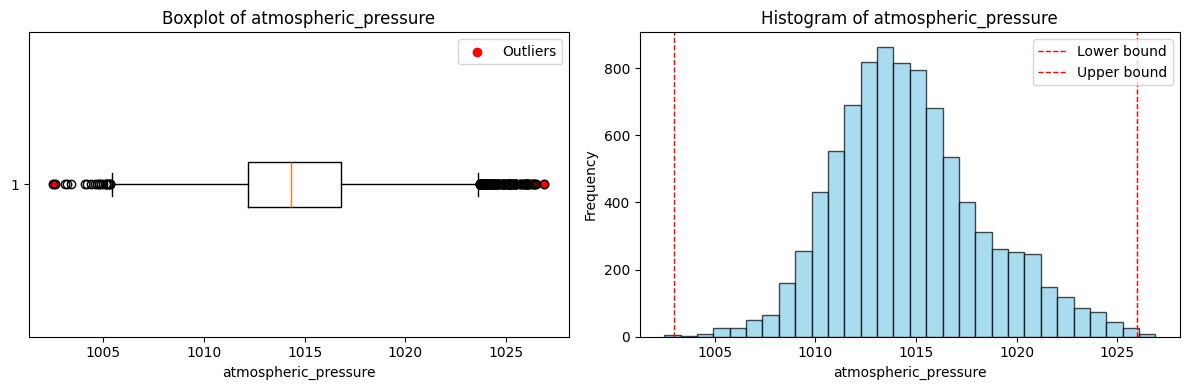

  air_temperature outlier row indices: [Timestamp('2024-04-11 09:00:00+0000', tz='UTC'), Timestamp('2024-04-11 10:00:00+0000', tz='UTC'), Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-11 13:00:00+0000', tz='UTC'), Timestamp('2024-04-11 14:00:00+0000', tz='UTC'), Timestamp('2024-04-11 15:00:00+0000', tz='UTC'), Timestamp('2024-04-11 16:00:00+0000', tz='UTC'), Timestamp('2024-04-11 17:00:00+0000', tz='UTC'), Timestamp('2024-04-11 18:00:00+0000', tz='UTC'), Timestamp('2024-04-12 09:00:00+0000', tz='UTC'), Timestamp('2024-04-12 10:00:00+0000', tz='UTC'), Timestamp('2024-04-12 11:00:00+0000', tz='UTC'), Timestamp('2024-04-12 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 13:00:00+0000', tz='UTC'), Timestamp('2024-04-12 14:00:00+0000', tz='UTC'), Timestamp('2024-04-12 15:00:00+0000', tz='UTC'), Timestamp('2024-08-03 12:00:00+0000', tz='UTC'), Timestamp('2024-08-03 13:00:00+0000', tz='UTC'), Timestamp('2024-08-03 14:00:0

In [59]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_cristianos for KNN outlier detection...
air_temperature


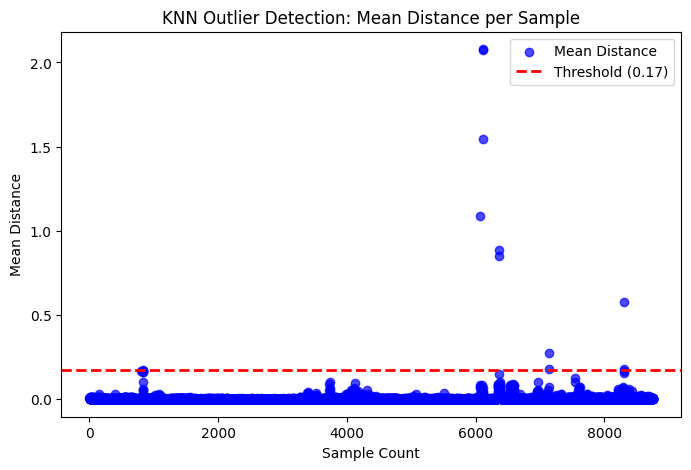

Detected 11 outliers at indices: [ 828 6065 6110 6111 6112 6371 6372 7135 7136 8309 8311]
atmospheric_pressure


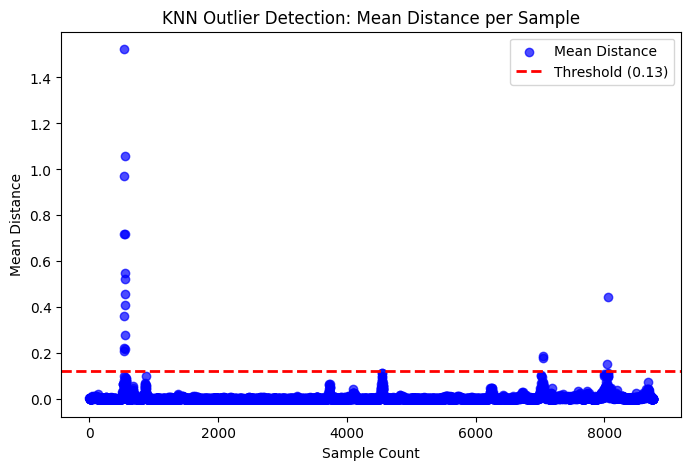

Detected 18 outliers at indices: [ 535  540  541  542  543  544  545  546  547  548  555  556  557  559
 7042 7043 8050 8051]
relative_humidity


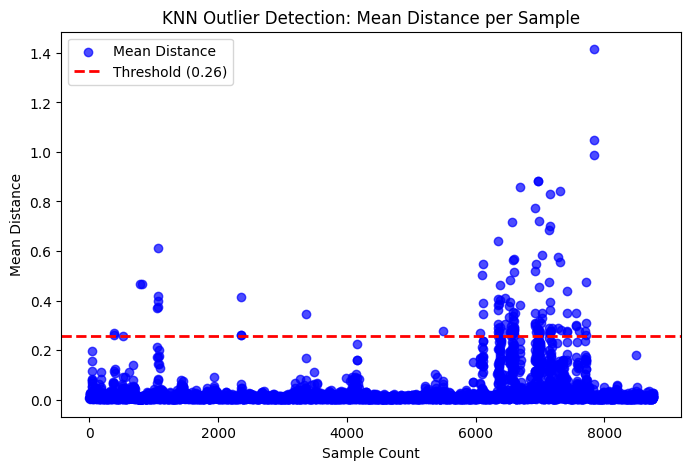

Detected 122 outliers at indices: [ 388  389  514  792  816 1053 1059 1060 1061 1062 2355 2356 2357 3365
 5500 6071 6106 6111 6119 6120 6342 6348 6349 6350 6353 6354 6355 6356
 6357 6371 6375 6380 6386 6458 6459 6460 6516 6520 6536 6537 6540 6544
 6553 6556 6557 6571 6573 6575 6577 6579 6580 6581 6583 6585 6590 6591
 6592 6593 6599 6600 6601 6602 6604 6609 6684 6698 6918 6919 6924 6925
 6926 6927 6932 6934 6955 6965 6968 6969 6973 6976 6981 6982 6983 6987
 6990 7001 7011 7036 7037 7039 7143 7144 7148 7149 7150 7151 7154 7155
 7156 7157 7169 7184 7274 7275 7305 7311 7329 7420 7421 7422 7424 7559
 7561 7562 7600 7704 7709 7711 7712 7834 7835 7836]
Processing openmeteo_cristianos for KNN outlier detection...
air_temperature


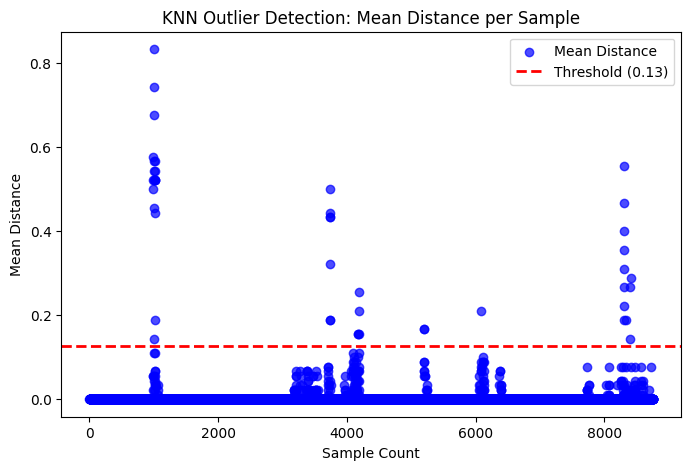

Detected 45 outliers at indices: [ 993  994  995  996  997  998  999 1000 1001 1002 1010 1017 1018 1019
 1020 1021 1022 1023 3732 3733 3734 3735 3736 3737 3738 4167 4169 4190
 4191 4192 5197 5200 6083 8306 8307 8308 8309 8310 8311 8312 8313 8336
 8406 8407 8408]
atmospheric_pressure


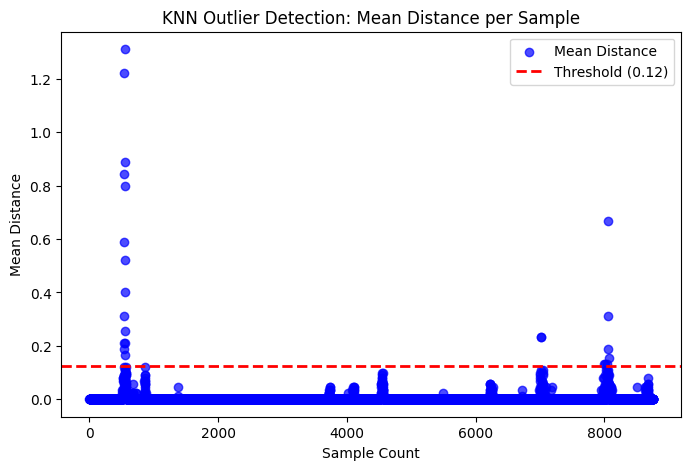

Detected 23 outliers at indices: [ 535  536  541  542  543  544  545  546  547  548  556  557  558  559
 7019 7020 8003 8004 8039 8051 8052 8053 8075]
relative_humidity


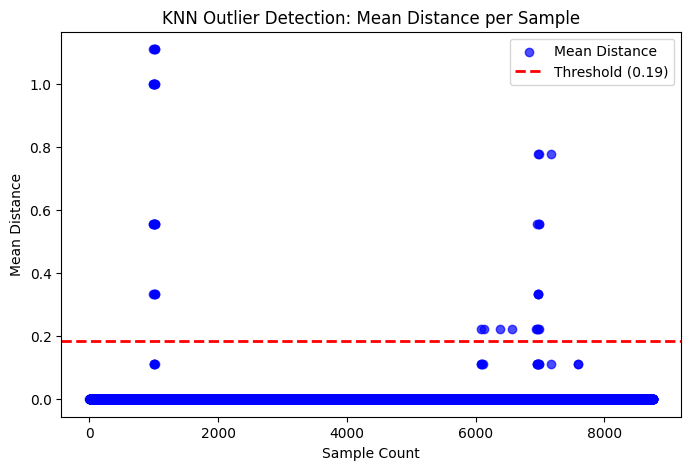

Detected 39 outliers at indices: [ 990  991  992  993  994  995  996  997  998  999 1000 1009 1010 1011
 1014 1015 1017 1018 1019 1020 1021 1022 6079 6131 6386 6563 6941 6954
 6960 6964 6966 6967 6968 6969 6982 6984 6985 6988 7176]


In [60]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_cristianos...


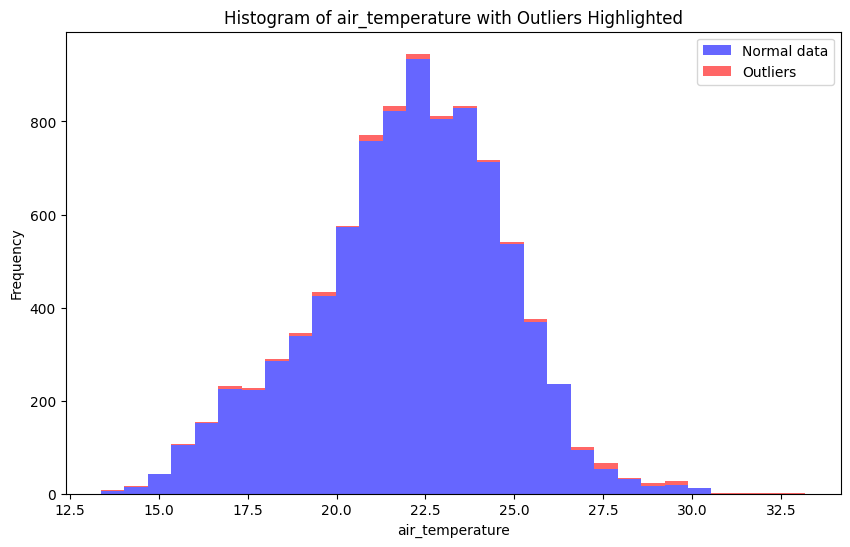

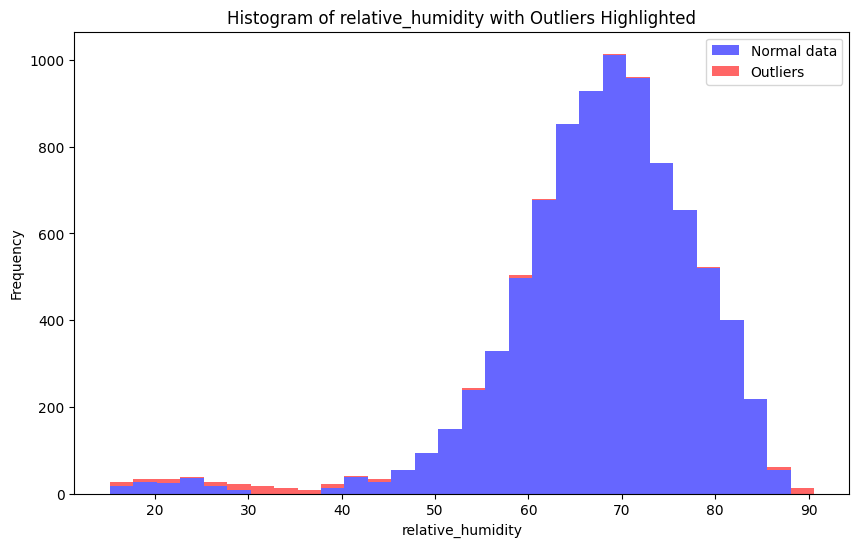

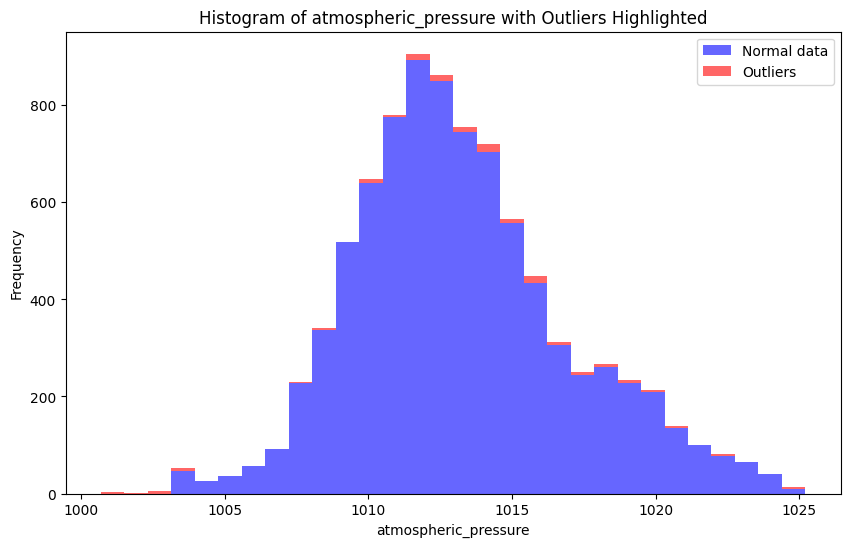

Plotting histogram for openmeteo_cristianos...


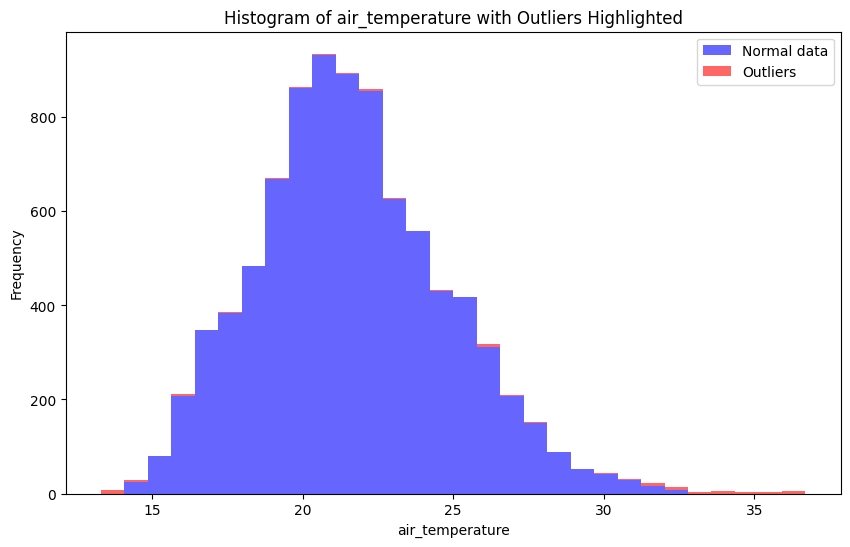

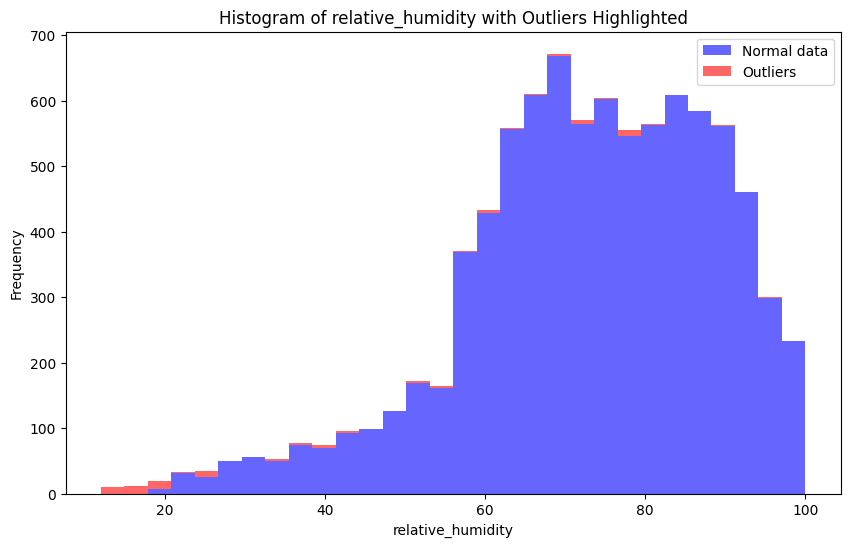

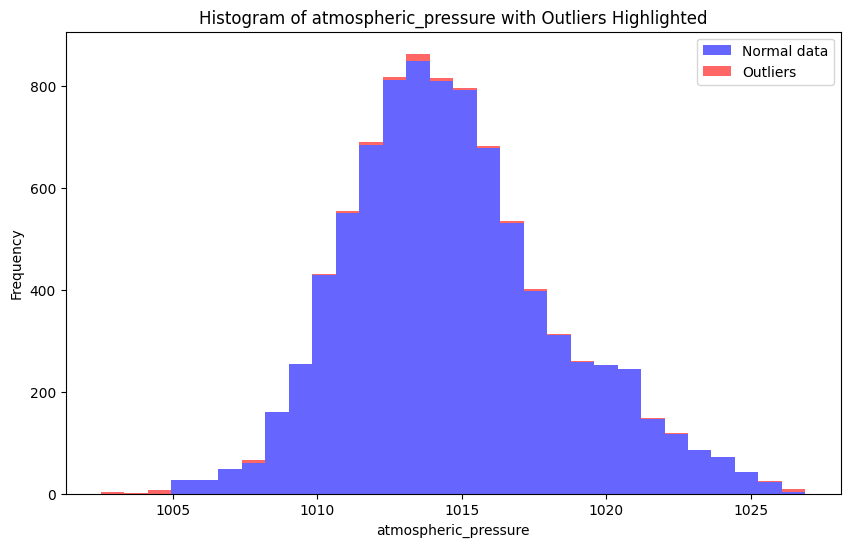

In [61]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [62]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_cristianos...
Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 1907.7258
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 1946.2121
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 2304.5378
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 8234.6457
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 11402.3537


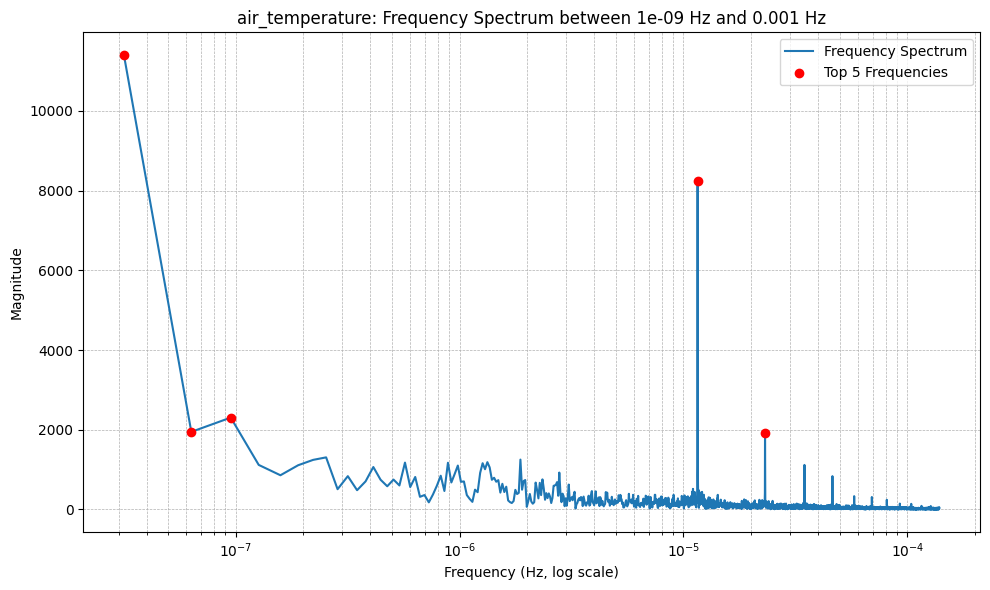

Top 5 frequencies with highest magnitude:
Frequency: 0.00000013 Hz, Period: 2190.00 hours, Magnitude: 13074.4779
Frequency: 0.00000044 Hz, Period: 625.71 hours, Magnitude: 13255.9432
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 17397.4463
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 19885.4647
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 24511.7142


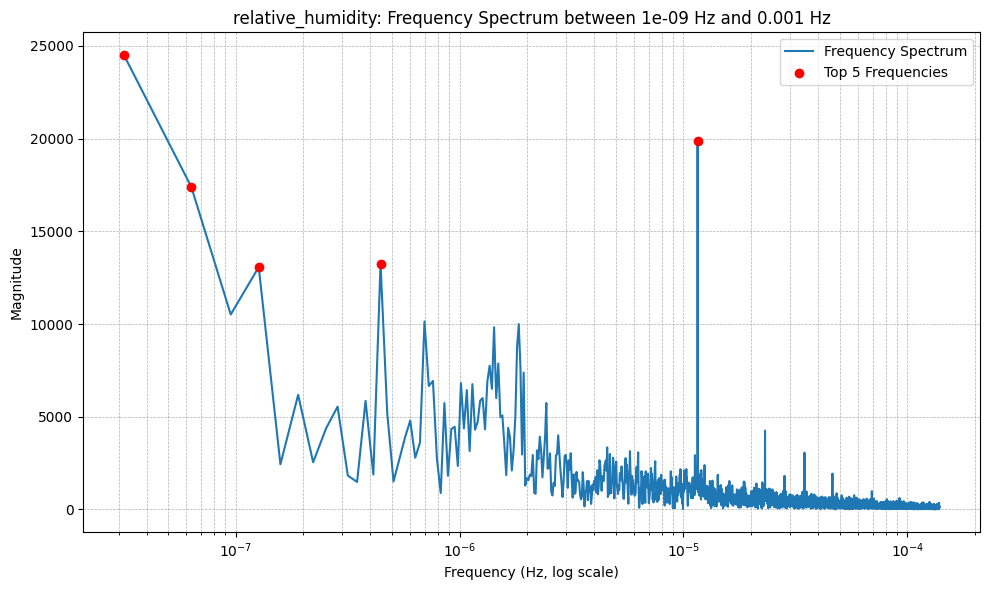

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3720.0284
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 4492.1916
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 6516.3432
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 7071.3650
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 12012.6023


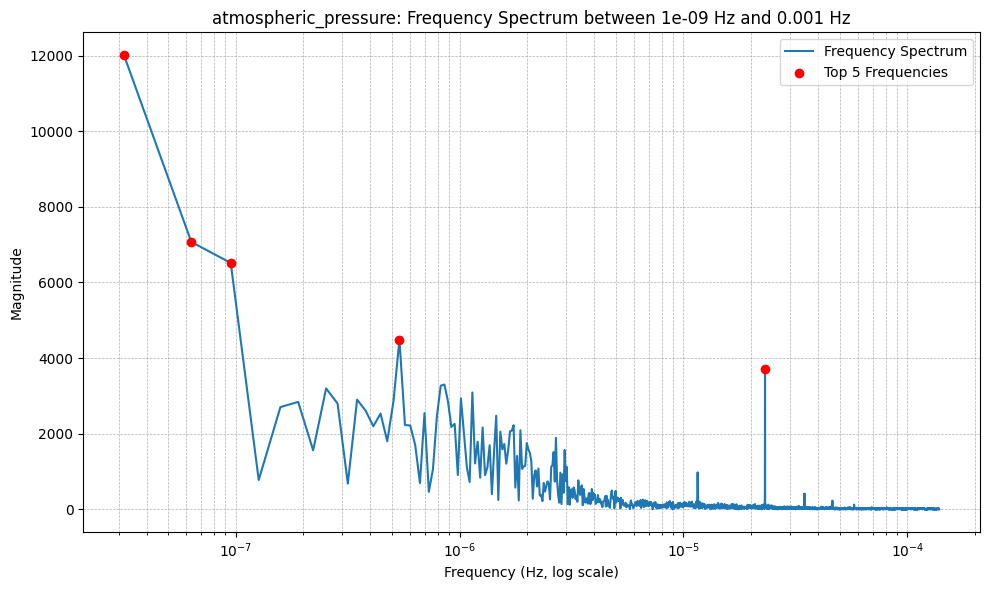

Plotting frequencies for openmeteo_cristianos...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 2675.9637
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 2978.7983
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 3923.7066
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 11128.5857
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 11309.5750


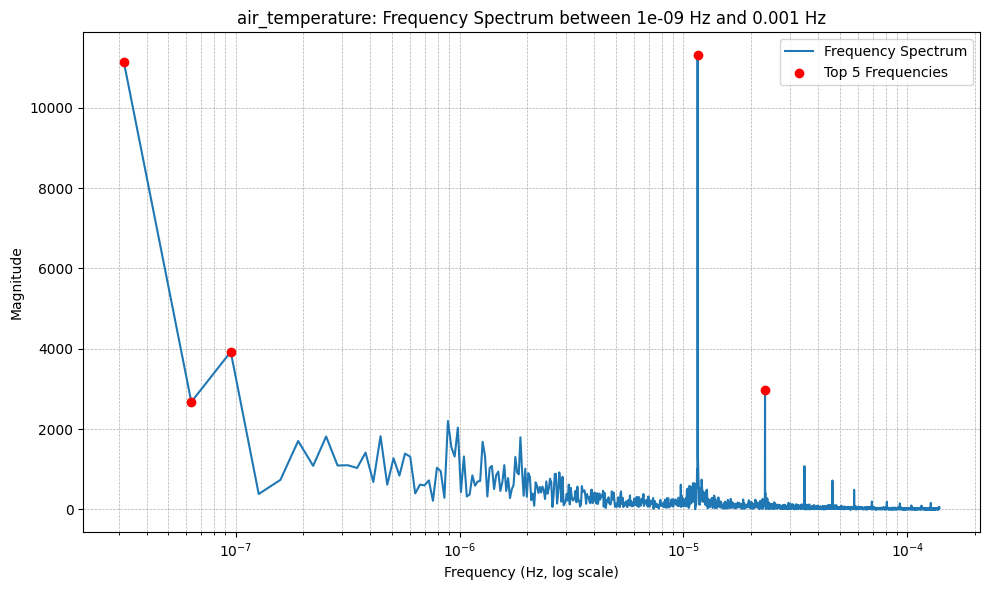

Top 5 frequencies with highest magnitude:
Frequency: 0.00000098 Hz, Period: 282.58 hours, Magnitude: 13566.1392
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 19401.8075
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 21083.9270
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 29933.8931
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 54316.0175


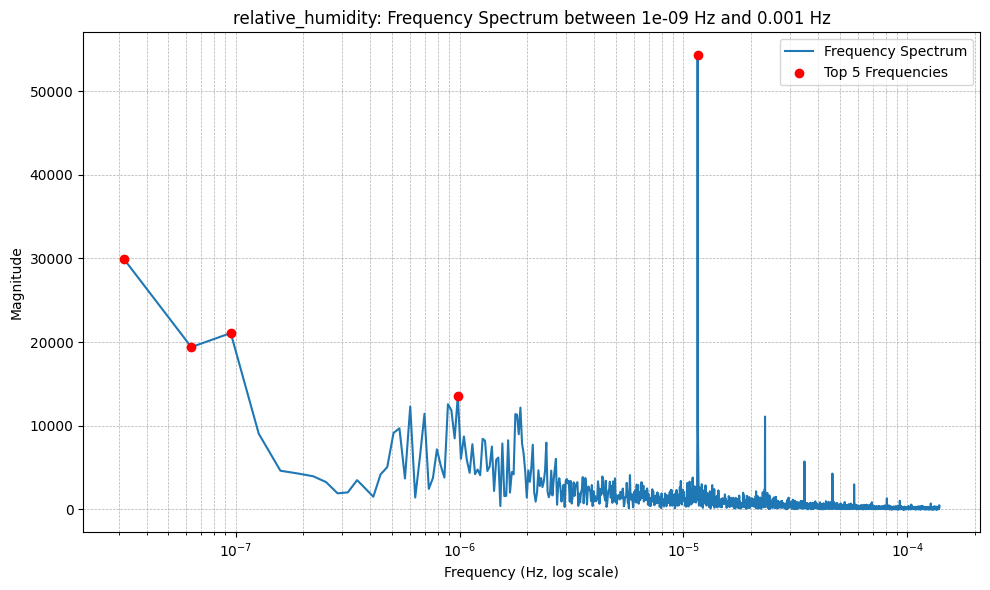

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3737.1950
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 4387.2902
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 6158.4134
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 6747.2857
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 11549.7372


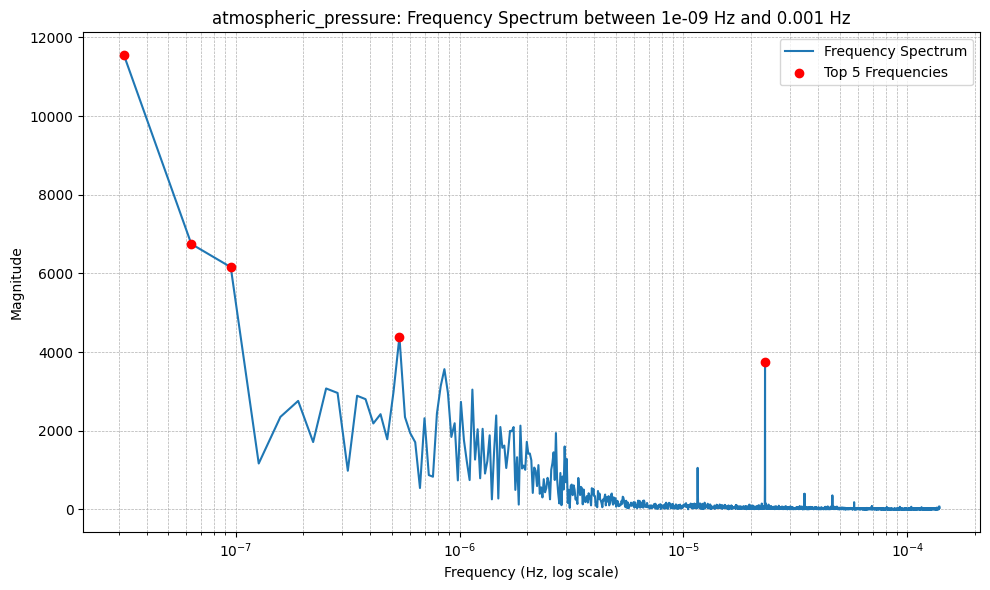

In [63]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [64]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_cristianos...


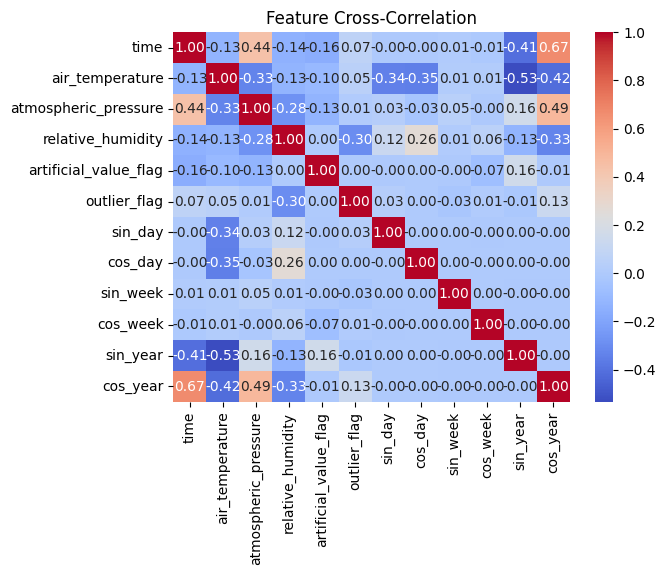

Plotting correlations for openmeteo_cristianos...


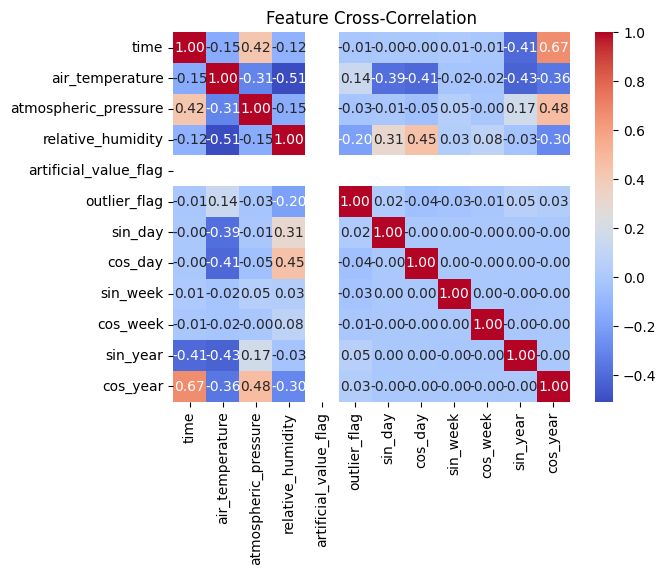

In [65]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [66]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [67]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)